# NFL PLayer Data Analysis
### By: Justin Pearson
ref: https://github.com/tbryan2/qb-passing-yards

In [131]:
# Dependencies
import nfl_data_py as nfl
import stat_collection as stats

# Basics / visualizations
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# ML
from pycaret.regression import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


# Display maximum columns
pd.set_option('display.max_columns', None)
#stats.to_csv('{}-{}playerstats.csv'.format(start_year, final_year)) # csv output format {year}playerstats.csv

# Set Year values here
### - Year is the most recent year you want in the dataset
### - years back is the amount of years you want to go back from the given year

In [132]:
# Set year of desired dataset and how many years to go back
year = 2023
years_back = 21

In [133]:
# get dataframes
pass_df, def_df = stats.get_stats(year, years_back)

2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [134]:
# Merge the defense and passer dataframes together
df = pass_df.merge(def_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# clean outliers from the data
df = df[df['pass_attempts_ewma_passer'] > 5]

df

,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
1,T. Maddox,PIT,DEN,2003,6,182.0,False,outdoors,grass,0.617457,33.019000,0.000000,0.000000,-7.356911,1.397267,3.440521,3.962471,0.285877,228.952256,NaN,True,0.646925,30.865384,152.444015,81.421414,-1.942906,0.775339,4.640252,3.335821,0.681728,223.685251,-1.369147
3,T. Maddox,PIT,SF,2003,11,327.0,False,outdoors,grass,0.572793,32.700456,0.000000,0.000000,-1.485736,1.049595,2.311225,2.488491,1.232645,229.066332,NaN,True,0.622482,38.316306,170.626914,71.700807,-5.889021,1.109830,4.534619,2.368317,1.231068,257.442445,-2.512900
5,D. Bledsoe,BUF,KC,2003,8,153.0,False,outdoors,grass,0.741935,31.000000,0.000000,0.000000,-20.606503,3.000000,2.000000,3.000000,0.000000,153.000000,NaN,True,0.663856,37.067093,204.471252,79.918622,-6.645185,1.998676,3.984328,2.822067,1.050271,262.900642,-0.575958
7,D. Bledsoe,BUF,NYJ,2002,12,181.0,False,outdoors,grass,0.652168,32.739851,0.000000,0.000000,-7.696496,1.469802,1.450000,2.400990,0.269554,170.825990,NaN,True,0.679719,33.271938,198.738045,107.374354,-3.976977,0.746339,3.990130,2.371585,1.527112,244.112816,0.407487
9,M.Mariota,TEN,NYJ,2015,14,274.0,False,outdoors,fieldturf,0.641662,24.783036,257.096892,76.043462,-2.522146,0.740166,4.187265,2.461289,1.044057,194.977138,-0.237148,True,0.572953,31.548845,285.418717,94.276457,-5.574083,1.118781,5.561243,3.478617,1.267904,227.728389,-5.068891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,Z.Wilson,NYJ,NO,2021,14,202.0,True,outdoors,fieldturf,0.559621,31.099333,234.219661,97.763225,-8.665527,0.583472,4.592910,3.383208,0.572110,181.513848,-11.106259,False,0.583487,33.704417,279.712932,107.353970,-1.892181,0.667250,4.866685,2.012722,1.524666,230.736073,-5.131266
14538,Z.Wilson,NYJ,HOU,2023,14,301.0,True,outdoors,fieldturf,0.594390,31.994333,234.910058,105.111596,-5.653010,0.476914,5.397769,3.495851,0.832883,203.335393,-7.218445,False,0.675567,33.704082,273.091110,125.571722,3.427975,0.685611,6.142070,2.043561,1.931466,282.488923,1.150190
14539,Z.Wilson,NYJ,DET,2022,15,317.0,True,outdoors,fieldturf,0.578188,31.018101,265.509988,95.989769,-5.383265,0.501146,6.326885,3.961415,0.921449,219.089479,-7.178459,False,0.642801,36.547989,344.845221,116.747585,0.337603,0.786055,4.691362,2.138538,1.852860,297.813277,0.418453
14540,Z.Wilson,NYJ,JAX,2021,16,102.0,True,outdoors,fieldturf,0.556806,26.391351,200.286134,74.827120,-5.804588,0.335148,5.638944,3.427655,0.798411,168.976820,-6.837090,False,0.672539,31.691650,253.237283,98.058178,5.163804,0.874484,4.828366,1.661366,1.536865,237.614188,2.080785


In [135]:
# further cleaning the data

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# encode the teams
df['defteam_encoded'] = label_encoder.fit_transform(df['defteam'])
df['posteam_encoded'] = label_encoder.fit_transform(df['posteam'])

# remove unnecessary columns
df = df.drop(columns = ['passer_player_name', 'posteam', 'defteam'])

# convert columns to binary
df['home_flag_passer'] = df['home_flag_passer'].astype(int)
df['home_flag_defense'] = df['home_flag_defense'].astype(int)

df['roof'] = df['roof'].map({'open': 1, 'outdoors': 0})
df['surface'] = df['surface'].map({'fieldturf': 1, 'grass': 0})

df = df.fillna(0)

df

,season,week,passing_yards,home_flag_passer,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,defteam_encoded,posteam_encoded
1,2003,6,182.0,0,0.0,0.0,0.617457,33.019000,0.000000,0.000000,-7.356911,1.397267,3.440521,3.962471,0.285877,228.952256,0.000000,1,0.646925,30.865384,152.444015,81.421414,-1.942906,0.775339,4.640252,3.335821,0.681728,223.685251,-1.369147,9,26
3,2003,11,327.0,0,0.0,0.0,0.572793,32.700456,0.000000,0.000000,-1.485736,1.049595,2.311225,2.488491,1.232645,229.066332,0.000000,1,0.622482,38.316306,170.626914,71.700807,-5.889021,1.109830,4.534619,2.368317,1.231068,257.442445,-2.512900,28,26
5,2003,8,153.0,0,0.0,0.0,0.741935,31.000000,0.000000,0.000000,-20.606503,3.000000,2.000000,3.000000,0.000000,153.000000,0.000000,1,0.663856,37.067093,204.471252,79.918622,-6.645185,1.998676,3.984328,2.822067,1.050271,262.900642,-0.575958,15,3
7,2002,12,181.0,0,0.0,0.0,0.652168,32.739851,0.000000,0.000000,-7.696496,1.469802,1.450000,2.400990,0.269554,170.825990,0.000000,1,0.679719,33.271938,198.738045,107.374354,-3.976977,0.746339,3.990130,2.371585,1.527112,244.112816,0.407487,24,3
9,2015,14,274.0,0,0.0,1.0,0.641662,24.783036,257.096892,76.043462,-2.522146,0.740166,4.187265,2.461289,1.044057,194.977138,-0.237148,1,0.572953,31.548845,285.418717,94.276457,-5.574083,1.118781,5.561243,3.478617,1.267904,227.728389,-5.068891,24,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,2021,14,202.0,1,0.0,1.0,0.559621,31.099333,234.219661,97.763225,-8.665527,0.583472,4.592910,3.383208,0.572110,181.513848,-11.106259,0,0.583487,33.704417,279.712932,107.353970,-1.892181,0.667250,4.866685,2.012722,1.524666,230.736073,-5.131266,22,24
14538,2023,14,301.0,1,0.0,1.0,0.594390,31.994333,234.910058,105.111596,-5.653010,0.476914,5.397769,3.495851,0.832883,203.335393,-7.218445,0,0.675567,33.704082,273.091110,125.571722,3.427975,0.685611,6.142070,2.043561,1.931466,282.488923,1.150190,12,24
14539,2022,15,317.0,1,0.0,1.0,0.578188,31.018101,265.509988,95.989769,-5.383265,0.501146,6.326885,3.961415,0.921449,219.089479,-7.178459,0,0.642801,36.547989,344.845221,116.747585,0.337603,0.786055,4.691362,2.138538,1.852860,297.813277,0.418453,10,24
14540,2021,16,102.0,1,0.0,1.0,0.556806,26.391351,200.286134,74.827120,-5.804588,0.335148,5.638944,3.427655,0.798411,168.976820,-6.837090,0,0.672539,31.691650,253.237283,98.058178,5.163804,0.874484,4.828366,1.661366,1.536865,237.614188,2.080785,14,24


# Passing Data Overview

In [136]:
# Get an overview of the data
df.describe().round(2)

,season,week,passing_yards,home_flag_passer,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,defteam_encoded,posteam_encoded
count,13404.00,13404.00,13404.00,13404.0,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.0,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00,13404.00
mean,2012.55,9.68,210.81,0.5,0.02,0.27,0.63,28.93,202.23,78.71,0.51,0.80,3.77,2.01,1.28,210.55,-0.47,0.5,0.64,32.98,228.37,88.62,-1.36,0.92,4.28,2.31,1.45,238.41,0.19,15.54,15.55
std,6.39,5.32,97.54,0.5,0.14,0.44,0.06,6.72,93.38,39.53,4.88,0.38,1.67,0.77,0.58,58.01,6.57,0.5,0.04,2.79,60.32,24.65,4.46,0.34,1.12,0.58,0.38,26.64,3.43,9.24,9.27
min,2002.00,1.00,-7.00,0.0,0.00,0.00,0.12,5.06,-7.00,0.00,-29.73,0.00,0.00,0.00,0.00,-1.00,-63.15,0.0,0.40,19.00,0.00,0.00,-23.96,0.00,0.00,0.00,0.00,131.00,-16.12,0.00,0.00
25%,2007.00,5.00,153.00,0.0,0.00,0.00,0.60,25.40,146.75,51.80,-2.59,0.54,2.61,1.51,0.89,176.70,-2.99,0.0,0.61,31.08,188.36,71.44,-4.30,0.68,3.48,1.91,1.19,220.68,-1.97,8.00,7.00
50%,2012.00,10.00,217.50,1.0,0.00,0.00,0.64,30.03,223.70,85.92,0.38,0.76,3.74,1.98,1.25,217.25,0.00,0.0,0.64,32.94,237.44,90.83,-1.35,0.89,4.24,2.26,1.44,238.33,0.23,16.00,16.00
75%,2018.00,14.00,277.00,1.0,0.00,1.00,0.67,33.58,271.97,107.74,3.69,1.01,4.89,2.46,1.67,251.82,3.11,1.0,0.66,34.79,271.30,105.77,1.65,1.13,5.04,2.68,1.70,255.79,2.44,24.00,24.00
max,2023.00,22.00,527.00,1.0,1.00,1.00,1.00,54.00,567.00,202.00,27.84,5.00,17.00,8.00,4.00,422.00,43.34,1.0,0.80,52.00,388.43,166.92,28.57,3.00,8.41,6.00,4.00,359.00,22.03,31.00,31.00


# Passing Data Heat Map

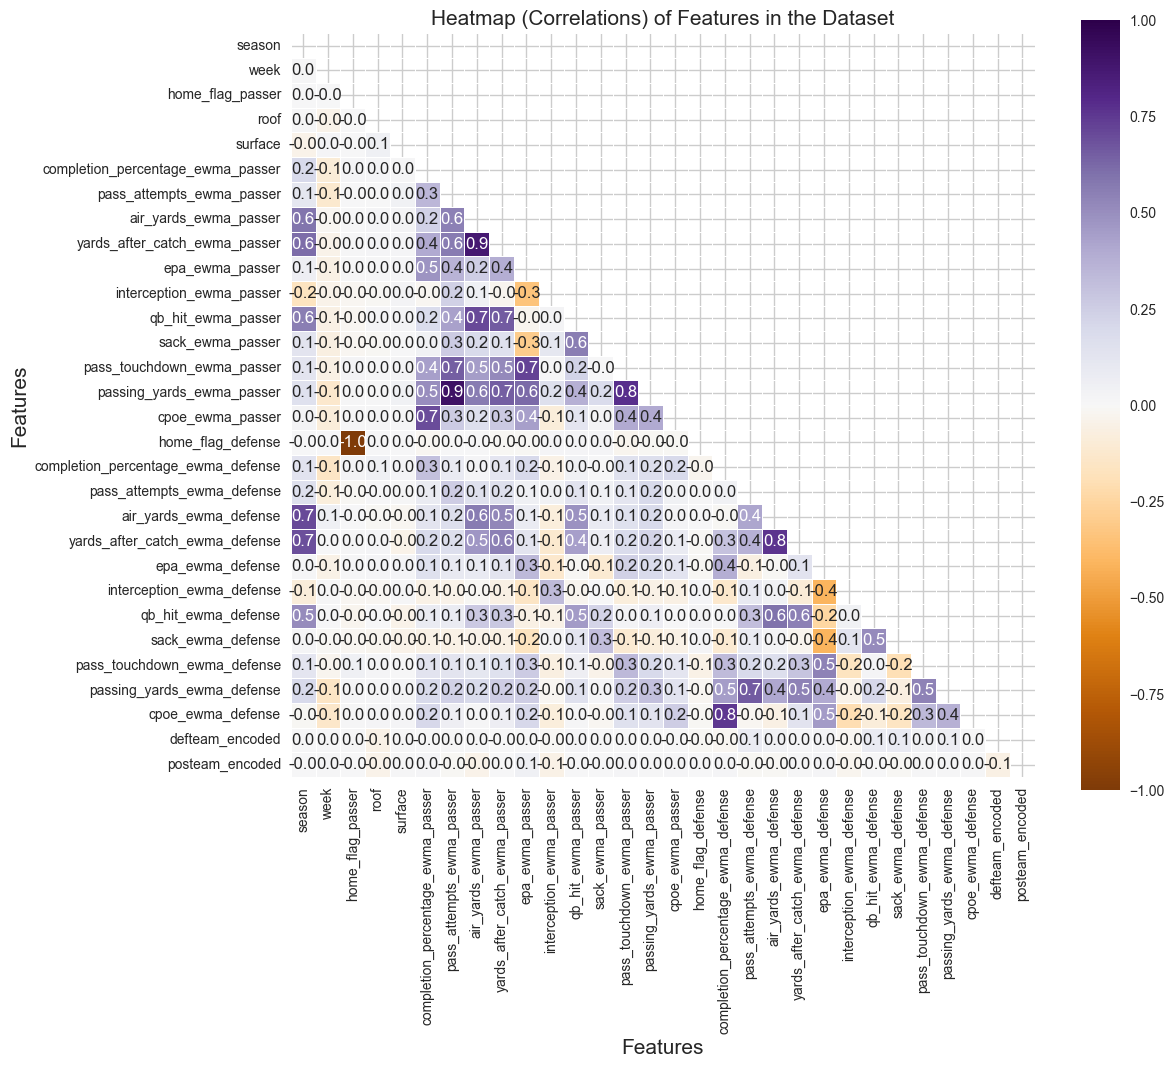

In [137]:
# Create a correlation for the dataset.
dataset_corr = df.select_dtypes(include=['number']).corr()

# Drop Agent_ID from correlation dataset.
dataset_corr = dataset_corr.drop(['passing_yards'], axis=1)
dataset_corr = dataset_corr.drop(['passing_yards'], axis=0)

# Create a correlation matrix. Only bottom left corner valued.
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

# Generate the corrleation matrix (heatmap) using Seaborn.
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center=0, vmin=-1, square=True,
                     cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 12}, fmt='.1f')
    plt.title('Heatmap (Correlations) of Features in the Dataset', fontsize=15)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Features', fontsize=15)
plt.show()

# Initial modelling with PyCaret

In [138]:
# Initialize PyCaret with default settings to start
setup = setup(data = df, target = 'passing_yards', session_id=123)

,Description,Value
0,Session id,123
1,Target,passing_yards
2,Target type,Regression
3,Original data shape,"(13404, 31)"
4,Transformed data shape,"(13404, 31)"
5,Transformed train set shape,"(9382, 31)"
6,Transformed test set shape,"(4022, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [139]:
# compare top 5 results from different models:
top5 = compare_models(n_select=5, exclude=(
    ['ransac', 'knn']), sort='RMSE', fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,51.7280,4367.3801,66.0820,0.5396,0.8532,0.9412,1.1340
lightgbm,Light Gradient Boosting Machine,51.6494,4383.1509,66.2042,0.5378,0.8416,0.9034,0.1260
lr,Linear Regression,52.3784,4458.6611,66.7688,0.5300,0.8709,0.9572,0.0360
ridge,Ridge Regression,52.3826,4459.3036,66.7736,0.5299,0.8714,0.9570,0.0200
et,Extra Trees Regressor,52.2301,4468.2855,66.8390,0.5290,0.8574,0.9350,0.5140
lar,Least Angle Regression,52.4737,4474.0475,66.8833,0.5284,0.8706,0.9568,0.0160
br,Bayesian Ridge,52.5232,4476.5708,66.9029,0.5281,0.8715,0.9580,0.0140
en,Elastic Net,52.5334,4478.0428,66.9139,0.5279,0.8716,0.9581,0.0180
llar,Lasso Least Angle Regression,52.5460,4479.8060,66.9271,0.5277,0.8717,0.9575,0.0140
lasso,Lasso Regression,52.5460,4479.8081,66.9271,0.5277,0.8717,0.9575,0.0220


In [140]:
#train lightgbm 10 more times since it was our best model
lightgbm = create_model('lightgbm', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,52.8695,4568.1786,67.5883,0.5112,0.7877,0.8132
1,52.2120,4397.8534,66.3163,0.5712,0.8879,0.9034
2,52.8672,4520.7023,67.2362,0.4917,0.8397,0.9823
3,49.4479,4126.1077,64.2348,0.5412,0.7714,0.7081
4,53.0865,4597.9376,67.8081,0.5154,0.8743,0.7721
5,49.4862,4082.1286,63.8915,0.5683,0.8586,0.8363
6,50.7642,4244.8207,65.1523,0.5595,0.8945,1.0084
7,51.8606,4334.9414,65.8403,0.5368,0.8085,0.9563
8,50.5023,4221.0893,64.9699,0.5422,0.8359,0.8481


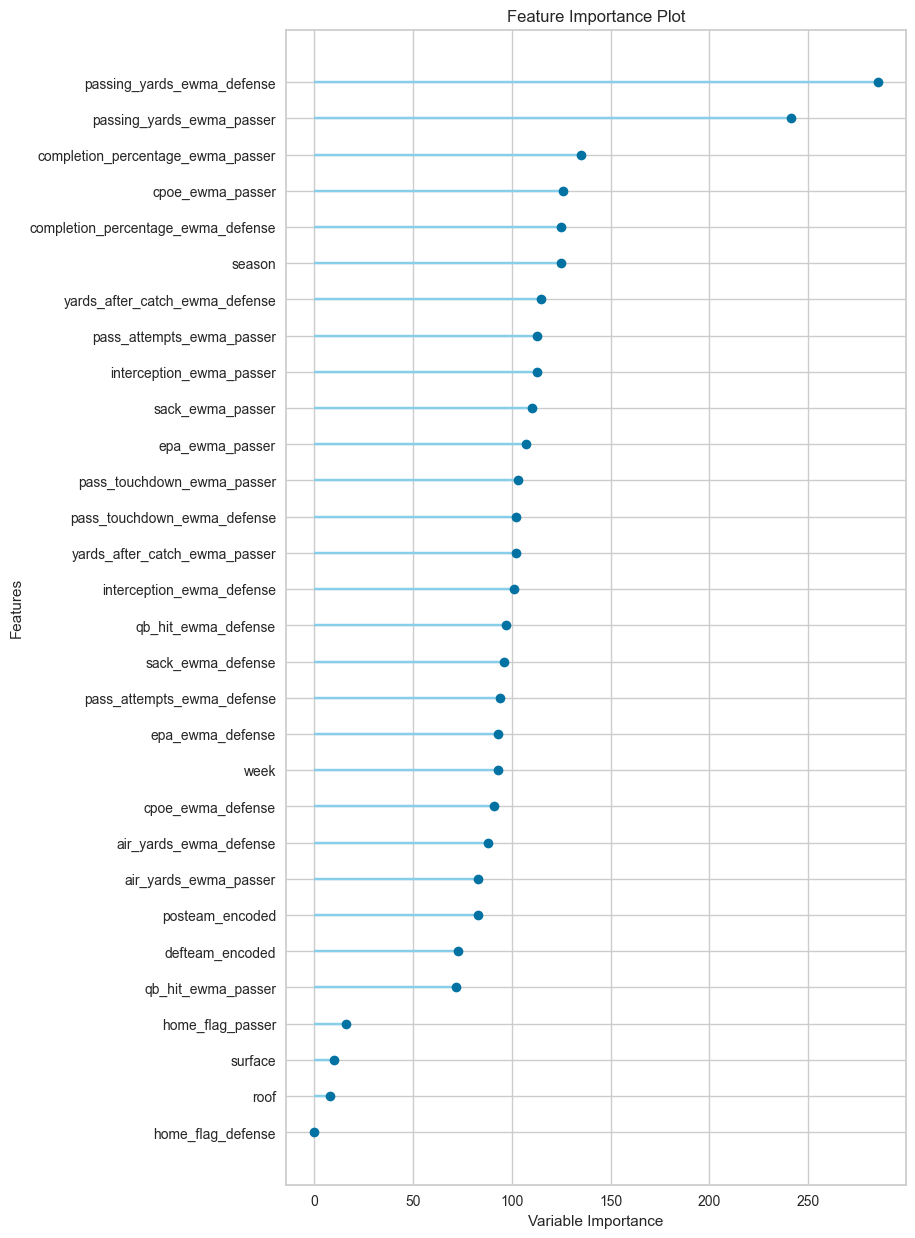

In [141]:
# plot how important 
plot_model(lightgbm, plot='feature_all')

# Machine Learning Using TensorFlow.Karas

In [142]:
# from our initial modelling we can see the importance of each value and change the weights of those columns accordingly
#get rid of irrelevant column
df = df.drop(columns = 'home_flag_defense')

# adjust weights
weights = np.array([1.3, 0.9, 1.0, 0.2, 0.1, 0.1, 1.4, 1.2, 0.8, 1.0, 1.1, 1.2, 0.7, 1.2, 1.0, 
                    2.4, 1.3, 1.3, 0.9, 0.8, 1.2, 0.9, 1.0, 1.0, 1.0, 1.0, 2.8, 0.9, 0.7, 0.8])

# Apply weights to the features
weighted_df = df * weights

In [144]:
# split the data
train_dataset, test_dataset = np.split(weighted_df, [int(.8 * len(weighted_df))])
train_dataset, val_dataset  = np.split(train_dataset, [int(.8 * len(train_dataset))])

# create the labels
train_labels, test_labels, val_labels  = train_dataset.pop('passing_yards'), test_dataset.pop('passing_yards'), val_dataset.pop('passing_yards')

In [159]:
# convert numpy arrays to tf datasets
train_ds   = tf.data.Dataset.from_tensor_slices((train_dataset.values, train_labels.values))
test_ds    = tf.data.Dataset.from_tensor_slices((test_dataset.values, test_labels.values))
val_ds     = tf.data.Dataset.from_tensor_slices((val_dataset.values, val_labels.values))

batch_size = 16
# shuffle and batch the datasets
train_ds = train_ds.shuffle(buffer_size = len(train_dataset)).batch(batch_size = batch_size)
test_ds  = test_ds.batch(batch_size = batch_size)
val_ds   = val_ds.batch(batch_size = batch_size)

In [160]:
#define model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape = (len(train_dataset.keys()),)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae', 'root_mean_squared_error'])

In [161]:
# Train the model
history = model.fit(train_ds, epochs = 10, validation_data = val_ds, verbose = 1)

Epoch 1/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - loss: 6628.9385 - mae: 63.9406 - root_mean_squared_error: 80.9611 - val_loss: 5156.2651 - val_mae: 55.7861 - val_root_mean_squared_error: 71.8071
Epoch 2/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 4950.7192 - mae: 55.6747 - root_mean_squared_error: 70.3493 - val_loss: 4813.4639 - val_mae: 53.6212 - val_root_mean_squared_error: 69.3791
Epoch 3/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 4974.6841 - mae: 55.9489 - root_mean_squared_error: 70.5243 - val_loss: 5282.1929 - val_mae: 56.6357 - val_root_mean_squared_error: 72.6787
Epoch 4/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 4880.1357 - mae: 54.9814 - root_mean_squared_error: 69.8118 - val_loss: 5433.1499 - val_mae: 57.4515 - val_root_mean_squared_error: 73.7099
Epoch 5/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 4835.5679 - mae: 54.7163 - root_mean_squared_error: 69.5295 - val_loss: 4786.4946 - val_mae: 53.4945 - val_root_mean_squared_error

In [162]:
# use our test dataset to see if the model is accurate enough
root_mean_squared_error, loss, mae = model.evaluate(test_ds, verbose=2)

168/168 - 0s - 531us/step - loss: 3842.7803 - mae: 49.0653 - root_mean_squared_error: 61.9902
